In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import glob
import jump_detect
from tqdm.auto import tqdm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats
from statsmodels.regression.rolling import RollingOLS
from tqdm.auto import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime as dt
from multiprocessing import Pool

sns.set_context("talk", font_scale=0.9)
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

# Load Data

In [2]:
%%time
## Load all the returns and create a merged dataframe
# Factor returns
print('Loading factors...')
mret_pivot_c_df = pd.concat([pd.read_parquet(x) for x in (glob.glob('../../data/proc/factor_returns_with_jumpind/*_cts.parquet'))])
mret_pivot_j_df = pd.concat([pd.read_parquet(x) for x in (glob.glob('../../data/proc/factor_returns_with_jumpind/*_jmp.parquet'))])
mret_pivot_df = mret_pivot_c_df.add(mret_pivot_j_df)

Loading factors...
CPU times: user 1.98 s, sys: 3.75 s, total: 5.73 s
Wall time: 2.49 s


# Identify Jumps

* Let y be some year
* Identify TOD adjustment year (y-1)
* Get IV pilot estimates using Bipower variation 
  * Use data from (t-1) from same year
  * For (y, t=0), get estimate from (y-1, t=T)
* Repeat for RV (needed for overnight)
* Pass estimates to jump identification function


## Functions

In [3]:
def get_indicators_for_year(data_df, year, lagged = False):

    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fix this
    if lagged:
        data_year_df = data_df.loc['1996':str(year-1)]
    else:
        data_year_df = data_df.loc[str(year)]
    
    # Compute indicators
    data_year_tod_df, data_year_bpt_df, data_year_rvt_df = jump_detect.compute_bp_var(data_year_df)

    return data_year_tod_df, data_year_bpt_df, data_year_rvt_df

In [4]:
def estimate_var_measure_oos(data_prev_var_df, data_curr_var_df, window=250, display_progess=False):
    # Estimate some variance measure out-of-sample
    # Step 1: Fit HAR model on previous data
    # Step 2: Use HAR model coefficients to make predictions
    #         in the new data
    
    # Estimate variance measure for next day using HAR
    results = {}

    for factor in tqdm(data_prev_var_df.columns, display=display_progess):

        ## Estimate HAR model on old data to get params
        # Set up regressors for HAR model
        y = data_prev_var_df[factor]
        x = data_prev_var_df[factor].shift(1)
        x5 = data_prev_var_df[factor].rolling(5).mean().shift(1)
        x21 = data_prev_var_df[factor].rolling(21).mean().shift(1)

        # Fit HAR model
        X = pd.concat([x, x5, x21], axis=1).dropna()
        fit_har = sm.OLS(y.loc[X.index], X).fit()

        ## Estimate BV using fitted HAR model predictions
        # Set up dataframe with both current and past data
        # Needed to make sure rolling regressors make sense
        data_both_var_df = pd.concat([data_prev_var_df, data_curr_var_df])

        # Set up X variables
        oos_x = data_both_var_df[factor].shift(1).fillna(0)
        oos_x5 = data_both_var_df[factor].rolling(5, min_periods=0).mean().shift(1).fillna(0)
        oos_x21 = data_both_var_df[factor].rolling(21, min_periods=0).mean().shift(1).fillna(0)
        oos_X = pd.concat([oos_x, oos_x5, oos_x21], axis=1)
        # oos_y_prediction = fit_har.predict(oos_X).loc[data_curr_var_df.index]
        rolling_fit = RollingOLS(
            data_both_var_df.loc[oos_X.index, factor], oos_X, window=window, min_nobs=5
        ).fit()
        oos_y_prediction = (
            np.multiply(rolling_fit.params.shift(1), oos_X)
            .sum(axis=1, skipna=False)
            .loc[data_curr_var_df.index]
        )

        # Check relationship between predictions and actual
        fit_diag = sm.OLS(data_curr_var_df[factor], oos_y_prediction).fit()

        # Save results for diagnostics
        results[factor] = [fit_har, fit_diag, oos_y_prediction]

    return results

In [41]:
def identify_jumps_adapted(data_df, year, har_window=60, alpha=4, omegabar=0.49):

    # !!!!!!!!
    # If its the first year in the sample, just do regular jump identification
    if year == np.min(data_df.index.year):

        data_pivot_df, data_pivot_c_df, data_pivot_j_df = jump_detect.detect_jumps(
            data_df.loc[str(year)].copy(), alpha=alpha, omegabar=omegabar, skip_resample=True
        )

        return data_pivot_df, data_pivot_c_df, data_pivot_j_df, []

    # Get indicators for previous year and current year
    data_prev_tod_df, data_prev_bpt_df, data_prev_rvt_df = get_indicators_for_year(
        data_df, year, lagged=True
    )
    data_curr_tod_df, data_curr_bpt_df, data_curr_rvt_df = get_indicators_for_year(data_df, year)

    # Set up tod indicator
    data_tod_df = data_prev_tod_df

    # Set up bipower and RV estimates
    def transform_var(x):
        return np.sqrt(x)
    def untransform_var(x):
        return np.square(x)
    
    bipower_est_results = estimate_var_measure_oos(
        transform_var(data_prev_bpt_df), transform_var(data_curr_bpt_df), window=har_window
    )
    rlzdvar_est_results = estimate_var_measure_oos(
        transform_var(data_prev_rvt_df), transform_var(data_curr_rvt_df), window=har_window
    )

    # Place holder values, overwrite next
    data_bpt_df = data_curr_bpt_df.copy()
    data_rvt_df = data_curr_rvt_df.copy()

    # Set variance estimates equal to OOS prediction from above results
    for col in data_bpt_df.columns:
        data_bpt_df[col] = untransform_var(bipower_est_results[col][-1])
        data_rvt_df[col] = untransform_var(rlzdvar_est_results[col][-1])

    # Identify jumps
    data_jumpid_raw_df = jump_detect.identify_jumps(
        data_df.loc[str(year)].copy(),
        data_tod_df,
        data_bpt_df,
        data_rvt_df,
        alpha=alpha,
        omegabar=omegabar,
    )

    # Clean up jump-identified rteurns
    data_jumpid_df = data_jumpid_raw_df[["datetime", "permno", "log_return", "is_jump"]].copy()
    data_jumpid_df["log_return_cts"] = data_jumpid_df["log_return"] * (
        1 - data_jumpid_df["is_jump"]
    )
    data_jumpid_df["log_return_jmp"] = data_jumpid_df["log_return"] * data_jumpid_df["is_jump"]
    data_jumpid_df = data_jumpid_df.rename(columns={"permno": "asset"})
    data_pivot_temp_df = data_jumpid_df.set_index("datetime")[
        ["asset", "log_return", "log_return_cts", "log_return_jmp"]
    ].pivot(columns=["asset"])

    # Pivotted returns, cts returns, and jump returns
    data_pivot_df = data_pivot_temp_df["log_return"].copy()
    data_pivot_c_df = data_pivot_temp_df["log_return_cts"].copy()
    data_pivot_j_df = data_pivot_temp_df["log_return_jmp"].copy()

    # # Fix labels if stocks
    # data_pivot_df.columns = [
    #     ("stock__" if (type(x) == int) else "") + str(x) for x in data_pivot_df.columns
    # ]
    # data_pivot_c_df.columns = [
    #     ("stock__" if (type(x) == int) else "") + str(x) for x in data_pivot_c_df.columns
    # ]
    # data_pivot_j_df.columns = [
    #     ("stock__" if (type(x) == int) else "") + str(x) for x in data_pivot_j_df.columns
    # ]

    # Extra info for diagnostics
    diag_info_list = [bipower_est_results, rlzdvar_est_results, data_jumpid_raw_df]

    return data_pivot_df, data_pivot_c_df, data_pivot_j_df, diag_info_list

## Tests

In [32]:
%%time
data_pivot_df, data_pivot_c_df, data_pivot_j_df, diag_info_list = identify_jumps_adapted(
    mret_pivot_df, 1996, alpha=4, omegabar=0.49
)

CPU times: user 3.16 s, sys: 719 ms, total: 3.88 s
Wall time: 3.78 s


In [42]:
%%time
data_pivot_df, data_pivot_c_df, data_pivot_j_df, diag_info_list = identify_jumps_adapted(
    mret_pivot_df[['ff__mkt']], 2020, alpha=4, omegabar=0.49, har_window=250
)

CPU times: user 2.3 s, sys: 2.05 s, total: 4.34 s
Wall time: 1.46 s


Text(0.5, 1.0, 'OOS Beta between predicted bipower variation \nand actual bipower variation')

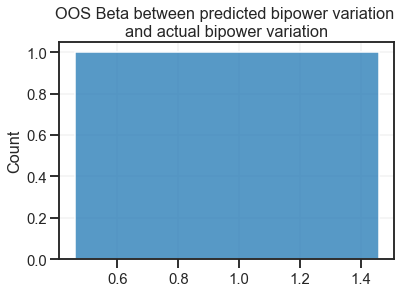

In [43]:
## Diagnostic checks on variance prediction

# OOS Beta between predicted bipower variation and actual bipower variation
sns.histplot(pd.Series([x[1].params[0] for key, x in diag_info_list[0].items()]))
plt.title('OOS Beta between predicted bipower variation \nand actual bipower variation')

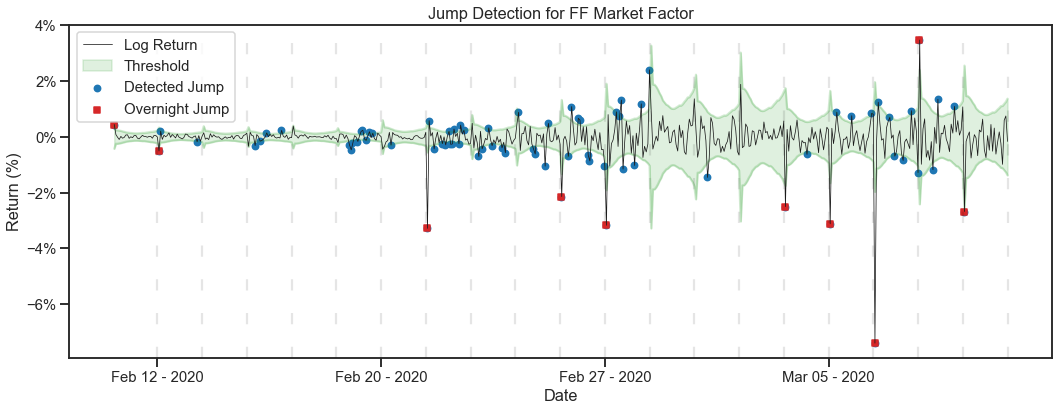

In [44]:
## Plot jump truncation

# Select data
sample_df = diag_info_list[-1].sort_values(by = 'datetime').set_index('datetime').query('permno == "ff__mkt"').reset_index().reset_index(drop = True).reset_index().copy()
n = pd.Series(mret_pivot_df.index).dt.time.nunique()
sample_df = sample_df.tail(n*225).head(n*20)

### Figure
fig, ax = plt.subplots(figsize = (15,6))

# Plot log return
sample_df.plot('index', 'log_return', label = 'Log Return', color = (0.1,0.1,0.1), lw = 0.75, zorder= 99, ax= ax)

# Lines for each day
sample_index_df = sample_df.groupby(pd.Grouper(key = 'datetime', freq = '1d')).last()['index'].dropna()
for key, val in sample_index_df.to_frame().iterrows():
    ax.axvline(x = val.iloc[0], color = 'k', ls = (0,(5,10)), alpha = 0.1)

# Plot threshold for jumps
ax.fill_between(sample_df['index'], -1*sample_df['cut'], sample_df['cut'], label = 'Threshold', color = 'tab:green', alpha = 0.15)
ax.plot(sample_df['index'], -1*sample_df['cut'], color = 'tab:green', alpha = 0.2)
ax.plot(sample_df['index'], sample_df['cut'], color = 'tab:green', alpha = 0.2)

# Plot threshold for jumps
ax.scatter(sample_df.query('is_jump == 1')['index'] -0.25, sample_df.query('is_jump == 1')['log_return'], 
           color = 'tab:blue', marker = 'o', s = 40, label = 'Detected Jump')
ax.scatter(sample_df.query('is_jump==1').loc[sample_df['timeofday'] == dt.time(9,30)]['index'] -0.25, sample_df.query('is_jump==1').loc[sample_df['timeofday'] == dt.time(9,30)]['log_return'], 
           color = 'tab:red', marker = 's', s = 30, alpha = 1, label = 'Overnight Jump')

# Plot options
ax.set_xticks(sample_index_df.iloc[::5].values)
ax.set_xticklabels(sample_index_df.iloc[::5].index.strftime('%b %d - %Y'))
ax.grid(False)
ax.legend(loc = 'best')
ax.set_xlabel(f"Date-Time Index (0 = {sample_df['datetime'].iloc[0]})")
# ax.set_ylim(-0.05, 0.05)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.set_ylabel('Return (%)')
ax.set_xlabel('Date')
ax.set_title('Jump Detection for FF Market Factor')
plt.tight_layout()

## Main

In [45]:
# Where to save the factor returns with identified jumps
output_folder = "../../data/proc/factor_returns_with_jumpind_adapted"

In [46]:
def helper_func(year):
    
    # Identify jumps
    data_pivot_df, data_pivot_c_df, data_pivot_j_df, diag_info_list = identify_jumps_adapted(
        mret_pivot_df, year, alpha=4, omegabar=0.49, har_window = 250
    )
    
    # Save results to temporary folder
    data_pivot_df.to_parquet(f"{output_folder}/{year}_all.parquet")
    data_pivot_c_df.to_parquet(f"{output_folder}/{year}_cts.parquet")
    data_pivot_j_df.to_parquet(f"{output_folder}/{year}_jmp.parquet")
    
    return 

with Pool(8) as p:
    
    year_list = np.unique(mret_pivot_df.index.year)
    
    for result in tqdm(p.imap_unordered(helper_func, year_list), total = len(year_list)):
        continue        

  0%|          | 0/25 [00:00<?, ?it/s]

### Aggregate processed returns

In [47]:
%%time
# Factor returns
print('Loading data...')
fret_pivot_df = pd.concat([pd.read_parquet(x) for x in (glob.glob(f'{output_folder}/*_all.parquet'))])
fret_pivot_c_df = pd.concat([pd.read_parquet(x) for x in (glob.glob(f'{output_folder}/*_cts.parquet'))])
fret_pivot_j_df = pd.concat([pd.read_parquet(x) for x in (glob.glob(f'{output_folder}/*_jmp.parquet'))])

Loading data...
CPU times: user 4.52 s, sys: 3.47 s, total: 7.98 s
Wall time: 3.34 s


In [48]:
%%time
# Save aggregated data for faster loading later
fret_pivot_df.reset_index().to_feather(f'{output_folder}/aggregated_all.feather')
fret_pivot_c_df.reset_index().to_feather(f'{output_folder}/aggregated_cts.feather')
fret_pivot_j_df.reset_index().to_feather(f'{output_folder}/aggregated_jmp.feather')

CPU times: user 2.23 s, sys: 1.58 s, total: 3.81 s
Wall time: 1.72 s


# Scratch

## Improving volatility estimation

In [25]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

In [26]:
def plot_factor_jumps(fig, ax, har_window = 250, factor_select = "ff__mkt"):

    # Get jump truncation
    data_pivot_df, data_pivot_c_df, data_pivot_j_df, diag_info_list = identify_jumps_adapted(
        mret_pivot_df[[factor_select]], 2020, alpha=4, omegabar=0.49, har_window=har_window
    )

    # Select data
    sample_df = (
        diag_info_list[-1]
        .sort_values(by="datetime")
        .set_index("datetime")
        .query('permno == @factor')
        .reset_index()
        .reset_index(drop=True)
        .reset_index()
        .copy()
    )
    n = pd.Series(mret_pivot_df.index).dt.time.nunique()
    sample_df = sample_df.tail(n * 225).head(n * 20)

    ### Figure
    # fig, ax = plt.subplots(figsize = (15,6))

    # Plot log return
    sample_df.plot(
        "index", "log_return", label="Log Return", color=(0.1, 0.1, 0.1), lw=0.75, zorder=99, ax=ax
    )

    # Lines for each day
    sample_index_df = (
        sample_df.groupby(pd.Grouper(key="datetime", freq="1d")).last()["index"].dropna()
    )
    for key, val in sample_index_df.to_frame().iterrows():
        ax.axvline(x=val.iloc[0], color="k", ls=(0, (5, 10)), alpha=0.1)

    # Plot threshold for jumps
    ax.fill_between(
        sample_df["index"],
        -1 * sample_df["cut"],
        sample_df["cut"],
        label="Threshold",
        color="tab:green",
        alpha=0.15,
    )
    ax.plot(sample_df["index"], -1 * sample_df["cut"], color="tab:green", alpha=0.2)
    ax.plot(sample_df["index"], sample_df["cut"], color="tab:green", alpha=0.2)

    # Plot threshold for jumps
    ax.scatter(
        sample_df.query("is_jump == 1")["index"] - 0.25,
        sample_df.query("is_jump == 1")["log_return"],
        color="tab:blue",
        marker="o",
        s=40,
        label="Detected Jump",
    )
    ax.scatter(
        sample_df.query("is_jump==1").loc[sample_df["timeofday"] == dt.time(9, 30)]["index"] - 0.25,
        sample_df.query("is_jump==1").loc[sample_df["timeofday"] == dt.time(9, 30)]["log_return"],
        color="tab:red",
        marker="s",
        s=30,
        alpha=1,
        label="Overnight Jump",
    )

    # Plot options
    ax.set_xticks(sample_index_df.iloc[::5].values)
    ax.set_xticklabels(sample_index_df.iloc[::5].index.strftime("%b %d - %Y"))
    ax.grid(False)
    ax.legend(loc="upper left")
    ax.set_xlabel(f"Date-Time Index (0 = {sample_df['datetime'].iloc[0]})")
    ax.set_ylim(-0.065, 0.065)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    ax.set_ylabel("Return (%)")
    ax.set_xlabel("Date")
    ax.set_title(f"Jump Detection for {factor_select.replace('__', ' ').upper()} - Window = {har_window}")
    plt.tight_layout()

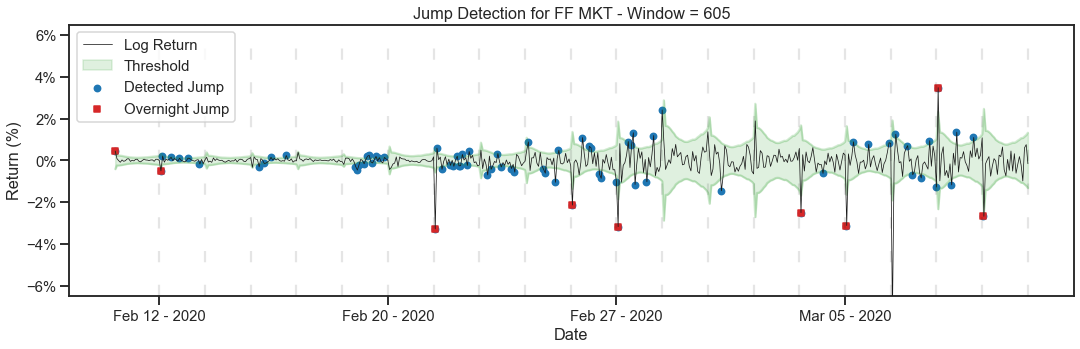

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=60, description='Window:', layout=Layout(width='50%'), max=1500, min=5),…

In [28]:
fig = plt.figure(figsize=(18, 5))
axes = fig.add_subplot(111)
plt.close()
hfig = display(fig, display_id=True)

def draw():
    #fig.clf()
    axes.plot(values, [v*v for v in values])
    axes.grid(False)
    axes.set_ylabel('Return (%)')
    fig.canvas.draw();
    hfig.update(fig);
    # time.sleep(1)

def update(har_window = 250, factor = 'ff__mkt'):
    
    if factor not in mret_pivot_df.columns:
        print('Invalid factor')
        return
    
    # Update plot
    axes.cla()
    plot_factor_jumps(fig, axes, har_window = har_window, factor_select = factor)
    fig.canvas.draw();
    hfig.update(fig);
    plt.show()
    

update()

factor_selector = widgets.Dropdown(
    options=[x for x in mret_pivot_df.columns if 'ff__' in x],
    value='ff__mkt',
    description='Factor:',
)
# year_slider = widgets.IntSlider(min=1996, max=2020, step = 1, value = 2020, description = 'Year:')
# date_index_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description = 'YearSlider:', layout=Layout(width='50%'))
window_slider = widgets.IntSlider(min=5, max=1500, step=1, value=60, description = 'Window:', layout=Layout(width='50%'))
interact(update, har_window = window_slider, factor = factor_selector );

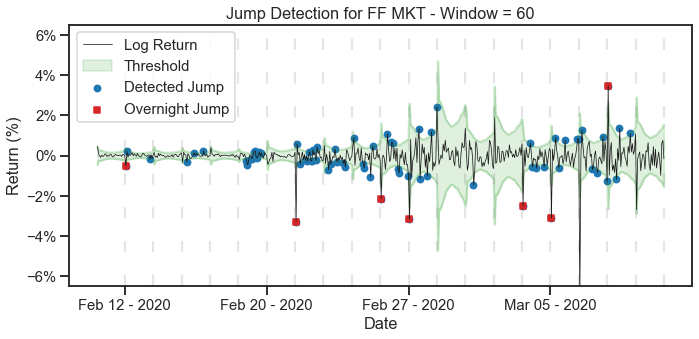

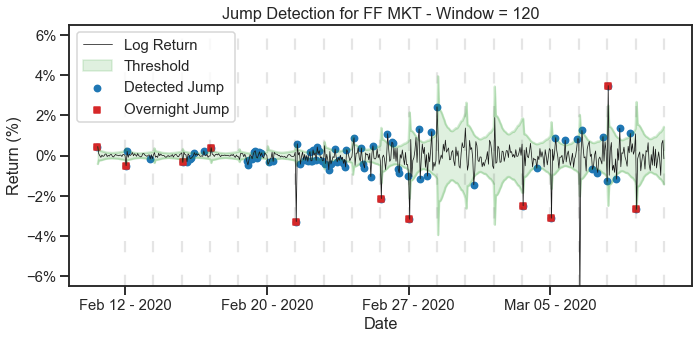

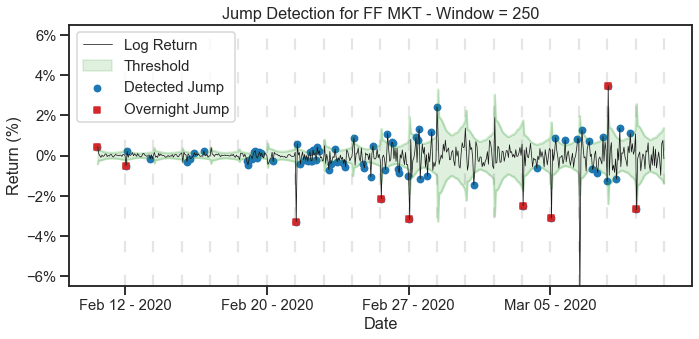

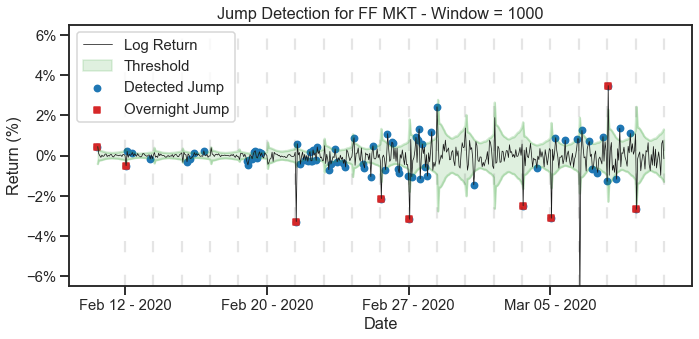

In [29]:
factor = 'ff__mkt'
fig, ax = plt.subplots(figsize = (10,5))
plot_factor_jumps(fig, ax, har_window = 60, factor_select = factor)
fig, ax = plt.subplots(figsize = (10,5))
plot_factor_jumps(fig, ax, har_window = 120, factor_select = factor)
fig, ax = plt.subplots(figsize = (10,5))
plot_factor_jumps(fig, ax, har_window = 250, factor_select = factor)
fig, ax = plt.subplots(figsize = (10,5))
plot_factor_jumps(fig, ax, har_window = 1000, factor_select = factor)